In [1]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git
# !pip install matplotlib pandas
# !pip3 install torch torchvision torchaudio


In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm
from torchmetrics.classification import BinaryAUROC


print("Torch version:", torch.__version__)


/home/ridwan.salahuddeen/.conda/envs/clipenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 1.13.0+cu117


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# !unzip -o -q ./hateful_memes.zip -d $HOME/.cache/torch/mmf/data/datasets/


In [5]:
!mkdir -p $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/{images,annotations,features/{train,test,val}}
# !mv $HOME/.cache/torch/mmf/data/datasets/hateful_memes/img/* $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images
# !mv $HOME/.cache/torch/mmf/data/datasets/hateful_memes/*.jsonl $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/


### Load Hateful Meme Dataset

In [6]:
import os

HOME = os.environ.get("HOME")
images_path = (
    f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/img/"
)
annotations_path = (
    f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/"
)
features_path = (
    f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/features/"
)


In [7]:
import pandas as pd

train = pd.read_json(f"{annotations_path}/train.jsonl", lines=True)
dev_seen = pd.read_json(f"{annotations_path}/dev_seen.jsonl", lines=True)
dev_unseen = pd.read_json(f"{annotations_path}/dev_unseen.jsonl", lines=True)
test_seen = pd.read_json(f"{annotations_path}/test_seen.jsonl", lines=True)
test_unseen = pd.read_json(f"{annotations_path}/test_unseen.jsonl", lines=True)


In [8]:
train.head()


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [9]:
# # Collect all the annotations (from Phase-2)
# train       = pd.read_json(f"{annotations_path}/train.jsonl", lines=True)
# dev_seen    = pd.read_json(f"{annotations_path}/dev_seen.jsonl", lines=True)
# dev_unseen  = pd.read_json(f"{annotations_path}/dev_unseen.jsonl", lines=True)
# test_seen   = pd.read_json(f"{annotations_path}/test_seen.jsonl", lines=True)
# test_unseen = pd.read_json(f"{annotations_path}/test_unseen.jsonl", lines=True)

# Create 2 sets:
#   A set of strings, 'a': for all the image names,
#   A set of lists, 'b': for all the image names in dataset, e.g. train, dev_seen, etc.
a = os.listdir(f"{images_path}")
b = []
for i in [train, dev_seen, dev_unseen, test_seen, test_unseen]:
    b.append(list(i["img"].str.split("/").str.get(1)))

set_mapping = ["train", "dev_seen", "dev_unseen", "test_seen", "test_unseen"]
total_size = 0
print("#of images in: ")
for idx, i in enumerate(b):
    total_size += len(set(i))
    print(f"\t'{set_mapping[idx]}'  \t:", len(set(i)))
else:
    print(
        f"\nIn total there are {total_size} images,",
        "\nBut the # of images in /img/ directory is: ",
        len(a),
    )


#of images in: 
	'train'  	: 8500
	'dev_seen'  	: 500
	'dev_unseen'  	: 540
	'test_seen'  	: 1000
	'test_unseen'  	: 2000

In total there are 12540 images, 
But the # of images in /img/ directory is:  12469


In [10]:
print(
    "#of images that are not in one of the .jsonl files: ",
    len(set(a).symmetric_difference(set(b[0] + b[1] + b[2] + b[3] + b[4]))),
)


#of images that are not in one of the .jsonl files:  329


In [11]:
print("#of same images in between: ")
for i in range(0, 5):
    print("\n")
    for j in range(0, 5):
        if i != j:
            print(
                f"{set_mapping[i], set_mapping[j]}   \t: {len(set(b[i]) & set(b[j]))}"
            )


#of same images in between: 


('train', 'dev_seen')   	: 0
('train', 'dev_unseen')   	: 0
('train', 'test_seen')   	: 0
('train', 'test_unseen')   	: 0


('dev_seen', 'train')   	: 0
('dev_seen', 'dev_unseen')   	: 400
('dev_seen', 'test_seen')   	: 0
('dev_seen', 'test_unseen')   	: 0


('dev_unseen', 'train')   	: 0
('dev_unseen', 'dev_seen')   	: 400
('dev_unseen', 'test_seen')   	: 0
('dev_unseen', 'test_unseen')   	: 0


('test_seen', 'train')   	: 0
('test_seen', 'dev_seen')   	: 0
('test_seen', 'dev_unseen')   	: 0
('test_seen', 'test_unseen')   	: 0


('test_unseen', 'train')   	: 0
('test_unseen', 'dev_seen')   	: 0
('test_unseen', 'dev_unseen')   	: 0
('test_unseen', 'test_seen')   	: 0


`dev_seen` has 100 images not in `dev_unseen`. Merging the 100 images to the train data as follows:

In [12]:
dev_seen.head()

img_100 = set(dev_seen["img"]).difference(dev_unseen["img"])
train_updated = pd.concat([train, dev_seen[dev_seen["img"].isin(img_100)]])
train_updated.to_json(
    f"{annotations_path}/train_updated.jsonl", orient="records", lines=True
)
train.shape, train_updated.shape


((8500, 4), (8600, 4))

## Write the dataset class

In [13]:
train.head(1)


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters


In [14]:
class HMDataset(Dataset):
    def __init__(
        self,
        images_path: str,
        annotation_path: str,
        features_path=None,
        feature_names_dict: dict = None,
        image_transform=None,
        text_transform=None,
    ) -> None:

        # Try to load features if previously saved and requested. If not saved, fall back to
        self.features_path = features_path
        self.feature_names_dict = feature_names_dict
        # self.images_features, self.text_features, self.labels = None, None, None
        if self.features_path:
            if not self.feature_names_dict:
                self.feature_names_dict = {
                    "image_features": "image_features.pt",
                    "text_features": "text_features.pt",
                    "label_features": "label_features.pt",
                }
                
            try:
                self.images_features = torch.load(f"{features_path}/{self.feature_names_dict['image_features']}")
                self.text_features = torch.load(f"{features_path}/{self.feature_names_dict['text_features']}")
                self.labels = torch.load(f"{features_path}/{self.feature_names_dict['label_features']}")
                return
            except FileNotFoundError as e:
                print(
                    "Unable to load fused_images_and_texts and/or labels from the paths provided. "
                    f"Falling back to loading actual datasets {e}"
                )

        self.images_path = images_path
        self.annotation_path = annotation_path
        self.image_transform = image_transform
        self.text_transform = text_transform
        assert self.annotation_path.endswith(
            ".jsonl"
        ), f"Invalid annotation file format. Format should be '.jsonl', not {self.annotation_path.split('.')[0]}"
        self.annotation: pd.DataFrame = pd.read_json(self.annotation_path, lines=True)

    def __len__(self):
        if hasattr(self, "labels"):
            return self.labels.shape[0]

        return self.annotation.shape[0]

    def __getitem__(self, index):
        if hasattr(self, "images_features") and hasattr(self, "text_features") and hasattr(self, "labels"):
            # print(self.images_features.shape, self.text_features.shape, self.labels.shape)
            return self.images_features[index], self.text_features[index], self.labels[index]

        img_path = os.path.join(self.images_path, self.annotation.loc[index, "img"])
        image = Image.open(img_path).convert("RGB")
        text = self.annotation.loc[index, "text"]
        label = self.annotation.loc[index, "label"]
        if self.image_transform:
            image = self.image_transform(image)
        if self.text_transform:
            text = self.text_transform(text)
        return image, text, torch.tensor(label)


In [15]:
import clip

clip.available_models()


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [16]:
model, preprocess = clip.load("ViT-L/14@336px")
model.to(device).eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)


Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408


In [17]:
clip.tokenize("This is awesome really" * 20, truncate=True)


tensor([[49406,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 43249,   589,   533,  1848,
         43249,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 43249,   589,   533,  1848,
         43249,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 43249,   589,   533,  1848,
         43249,   589,   533,  1848, 43249,   589,   533,  1848, 43249,   589,
           533,  1848, 43249,   589,   533,  1848, 49407]], dtype=torch.int32)

In [18]:
train_features_path = os.path.join(features_path,"train")
hm_train = HMDataset(
    images_path,
    f"{annotations_path}/train_updated.jsonl",
    image_transform=preprocess,
    text_transform=clip.tokenize,
    features_path=train_features_path,
)

len(hm_train[0])

3

In [19]:
hm_dataset = HMDataset(
    images_path,
    f"{annotations_path}/train_updated.jsonl",
)
len(hm_dataset)


8600

In [20]:
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image

from collections import OrderedDict


/tmp/ipykernel_3279748/338045466.py:9: DeprecationWarning: This function is deprecated. Please call randint(0, 8600 + 1) instead
  for i, idx in enumerate(np.random.random_integers(0, len(hm_dataset), 9)):


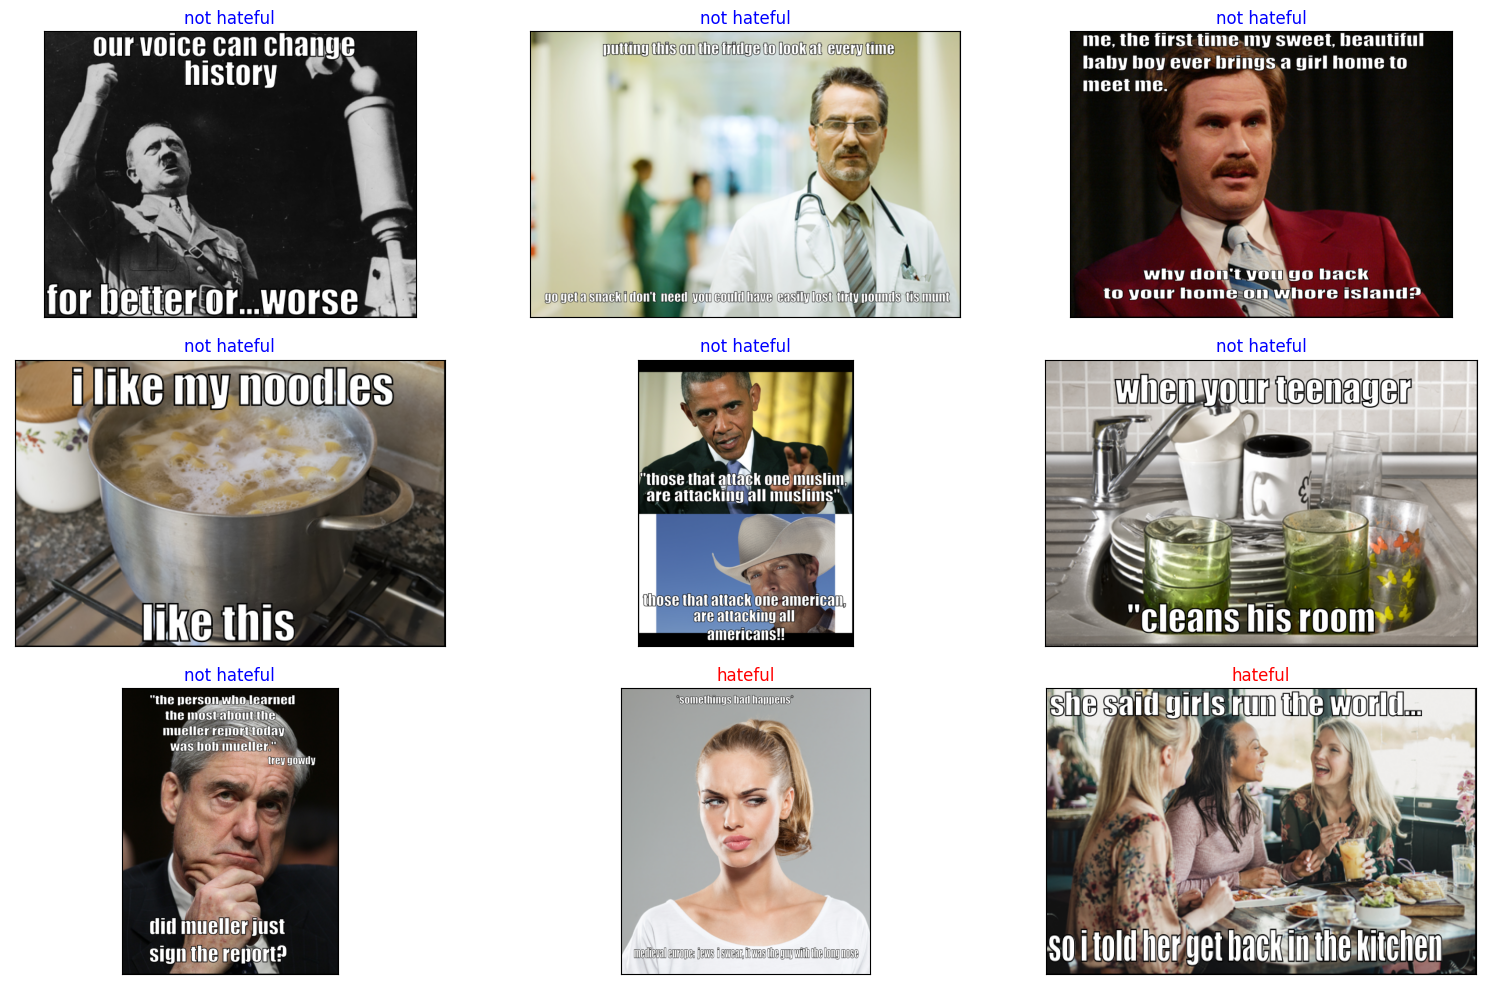

In [21]:
hm_dataset = HMDataset(
    images_path, f"{annotations_path}/train_updated.jsonl", image_transform=None
)

plt.figure(figsize=(16, 10))

label_map = {1: "hateful", 0: "not hateful"}

for i, idx in enumerate(np.random.random_integers(0, len(hm_dataset), 9)):
    image, text, label = hm_dataset[idx]

    plt.subplot(3, 3, i + 1)
    # C, W, H = image.shape
    # image = image.convert("RGB")
    plt.imshow(image)
    plt.title(label_map[label.item()], color="r" if label else "b")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()


In [22]:
import torch.nn as nn
import torch.nn.functional as F


class HMMLP(nn.Module):
    def __init__(
        self,
        n_in=512 * 2,
        n_out=1,
    ) -> None:
        super().__init__()

        self.fc1 = nn.Linear(n_in, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, n_out)

    def forward(self, x):

        # x = self.fc1(x)
        x = F.dropout(F.relu(self.fc1(x)), p=0.3)
        x = F.dropout(F.relu(self.fc2(x)), p=0.3)
        x = F.dropout(F.relu(self.fc3(x)), p=0.2)
        x = self.fc4(x)

        return x


In [23]:
batch_size = 64


def text_preprocess(text):
    return clip.tokenize(text, truncate=True)

def get_dataloaders(get_source_data=True):
    if get_source_data:
        train_features_path = None
        test_features_path = None
        val_features_path = None

    else:
        train_features_path = os.path.join(features_path,"train")
        test_features_path = os.path.join(features_path, "test")
        val_features_path = os.path.join(features_path, "val")

    hm_train_dataset = HMDataset(
        images_path,
        f"{annotations_path}/train_updated.jsonl",
        image_transform=preprocess,
        text_transform=text_preprocess,
        features_path=train_features_path,
    )
    hm_test_dataset = HMDataset(
        images_path,
        f"{annotations_path}/test_unseen.jsonl",
        image_transform=preprocess,
        text_transform=text_preprocess,
        features_path=test_features_path,
    )
    hm_val_dataset = HMDataset(
        images_path,
        f"{annotations_path}/dev_unseen.jsonl",
        image_transform=preprocess,
        text_transform=text_preprocess,
        features_path=val_features_path,
    )

    train_dataloader = DataLoader(hm_train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(hm_test_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(hm_val_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, test_dataloader, val_dataloader


In [24]:
# train_dataloader, test_dataloader, val_dataloader = get_dataloaders(False)


In [25]:
train_dataloader, test_dataloader, val_dataloader = get_dataloaders()
data = next(iter(train_dataloader))

In [26]:
images, texts, labels = data
images.shape, texts.shape, labels.shape


(torch.Size([64, 3, 336, 336]), torch.Size([64, 1, 77]), torch.Size([64]))

In [27]:
net = HMMLP(n_in=1536)
images, texts, labels = data
images = images.to(device)
texts = texts.to(device)
labels = labels.to(device).float()

with torch.no_grad():
    images = model.encode_image(images)
    texts = model.encode_text(texts.squeeze())


In [28]:
images.shape, texts.shape, labels.shape

(torch.Size([64, 768]), torch.Size([64, 768]), torch.Size([64]))

In [29]:
net = net.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
optimizer.zero_grad()

In [30]:
fused = torch.hstack((images, texts))
fused.requires_grad


False

In [31]:
fused.requires_grad_()
fused.requires_grad


True

In [32]:
output = net(fused.float())


In [33]:
output.shape, labels.shape


(torch.Size([64, 1]), torch.Size([64]))

In [34]:
labels.squeeze()


tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [35]:
output.squeeze(), labels.squeeze()


(tensor([-0.1155, -0.0723, -0.1680, -0.2063, -0.0587, -0.1830, -0.0900, -0.1144,
         -0.1424, -0.1475, -0.1400, -0.1438, -0.1236, -0.1303, -0.1333, -0.1488,
         -0.1742, -0.1695, -0.1626, -0.1721, -0.1661, -0.0970, -0.1575, -0.0753,
         -0.1391, -0.1321, -0.0980, -0.1201, -0.1401, -0.1329, -0.1614, -0.1702,
         -0.1906, -0.1291, -0.1609, -0.1606, -0.1582, -0.1636, -0.0918, -0.1618,
         -0.0958, -0.1676, -0.1650, -0.1352, -0.1021, -0.0997, -0.1582, -0.1648,
         -0.2224, -0.1491, -0.2023, -0.1834, -0.1606, -0.1764, -0.1443, -0.1489,
         -0.1846, -0.0843, -0.2182, -0.1788, -0.1522, -0.1382, -0.1497, -0.1696],
        device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
         0., 1., 1., 0., 0., 0., 0., 0., 0., 0.], devi

In [36]:
o = output.squeeze().round()


In [37]:
sum(o == labels)


tensor(44, device='cuda:0')

In [38]:
loss = criterion(output.squeeze(), labels.squeeze())
loss.backward()
optimizer.step()

In [40]:
net = HMMLP(n_in=fused.shape[1]+fused.shape[1]//2)
net = net.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

epochs = 10
print_every = 50
image_features = torch.Tensor()
text_features = torch.Tensor()
label_features = torch.Tensor()
# labels_train = torch.Tensor()
# fused_images_texts_features_val = torch.Tensor()
# labels_val = torch.Tensor()
data_from_source = False
train_dataloader, test_dataloader, val_dataloader = get_dataloaders(get_source_data=data_from_source)

for epoch in range(epochs):

    running_loss = 0
    for i, data in enumerate(tqdm(train_dataloader), 0):
        images, texts, labels = data
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.float().squeeze().to(device)

        if data_from_source:
            with torch.no_grad():
                images = model.encode_image(
                    images
                )  # input_dim: batch_size x 3 x H x W; output_dim: batch_size x 512
                texts = model.encode_text(
                    texts.squeeze()
                )  # input_dim: batch_size x 77; output_dim: batch_size x 512

            # images = images / images.norm(dim=1, keepdim=True)
            # texts = texts / texts.norm(dim=1, keepdim=True)
        
        if epoch == 0 and data_from_source:
            image_features = torch.cat((image_features, images.cpu().clone().detach()))
            text_features = torch.cat((text_features, texts.cpu().clone().detach()))
            label_features = torch.cat((label_features, labels.cpu().clone().detach()))

        fused_images_texts = torch.hstack((images, texts, (images+texts)/torch.tensor(2)))
        fused_images_texts = fused_images_texts / fused_images_texts.norm(dim=1, keepdim=True)

        fused_images_texts.requires_grad_()
        fused_images_texts = fused_images_texts.float()

        optimizer.zero_grad()

        # Forward pass on the fused data

        output = net(fused_images_texts)

        loss = criterion(output.squeeze(), labels)

        # Compute gradient
        loss.backward()
        # Update weight
        optimizer.step()

        running_loss += loss.item()

        if i % print_every == (print_every - 1):

            print(
                f"[Epoch {epoch + 1}, step {i+1:3d}] loss: {running_loss/print_every:.5f}"
            )
            running_loss = 0.0

    if epoch == 0 and data_from_source:
        torch.save(
            image_features, os.path.join(features_path, "train", "image_features.pt")
        )
        torch.save(
            text_features, os.path.join(features_path, "train", "text_features.pt")
        )
        torch.save(
            label_features, os.path.join(features_path, "train", "label_features.pt")
        )

    ## Switch to eval mode
    net.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    image_features = torch.Tensor()
    text_features = torch.Tensor()
    label_features = torch.Tensor()
    for i, data in enumerate(tqdm(val_dataloader), 0):

        images, texts, labels = data
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.float().squeeze().to(device)

        if data_from_source:
            with torch.no_grad():
                images = model.encode_image(
                    images
                )  # input_dim: batch_size x 3 x H x W; output_dim: batch_size x 512
                texts = model.encode_text(
                    texts.squeeze()
                )  # input_dim: batch_size x 77; output_dim: batch_size x 512
            
            # images = images / images.norm(dim=1, keepdim=True)
            # texts = texts / texts.norm(dim=1, keepdim=True)

        if epoch == 0 and data_from_source:
            image_features = torch.cat((image_features, images.cpu().clone().detach()))
            text_features = torch.cat((text_features, texts.cpu().clone().detach()))
            label_features = torch.cat((label_features, labels.cpu().clone().detach()))

        fused_images_texts = torch.hstack((images, texts, (images+texts)/torch.tensor(2)))
        fused_images_texts = fused_images_texts / fused_images_texts.norm(dim=1, keepdim=True)

        # fused_images_texts.requires_grad_()
        fused_images_texts = fused_images_texts.float()

        with torch.no_grad():
            output = net(fused_images_texts)

        loss = criterion(output.squeeze(), labels)

        running_loss += loss.item()

        correct_preds += sum(torch.sigmoid(output).squeeze().round() == labels)
        total_preds += len(labels)
        auroc = BinaryAUROC(pos_label=1)
        auroc_score = auroc(output, labels.int())

    print(
        f"[Epoch {epoch +1}, step {i+1:3d}] val loss: {running_loss/i+1:.5f} accuracy: {correct_preds/total_preds} auroc: {auroc_score}"
    )

    if epoch == 0 and data_from_source:
        torch.save(
            image_features, os.path.join(features_path, "val", "image_features.pt")
        )
        torch.save(
            text_features, os.path.join(features_path, "val", "text_features.pt")
        )
        torch.save(
            label_features, os.path.join(features_path, "val", "label_features.pt")
        )
    net.train()


print("Finished Training!")

Unable to load fused_images_and_texts and/or labels from the paths provided. Falling back to loading actual datasets [Errno 2] No such file or directory: '/home/ridwan.salahuddeen/.cache/torch/mmf/data/datasets/hateful_memes/defaults/features/test/image_features.pt'


 51%|█████     | 69/135 [00:00<00:00, 120.37it/s]

[Epoch 1, step  50] loss: 0.65759


 91%|█████████ | 123/135 [00:01<00:00, 120.55it/s]

[Epoch 1, step 100] loss: 0.55637


100%|██████████| 9/9 [00:00<00:00, 131.32it/s]


[Epoch 1, step   9] val loss: 1.71284 accuracy: 0.6388888955116272 auroc: 0.6363636255264282


 46%|████▌     | 62/135 [00:00<00:00, 168.76it/s]

[Epoch 2, step  50] loss: 0.47433


 96%|█████████▌| 129/135 [00:00<00:00, 133.60it/s]

[Epoch 2, step 100] loss: 0.46186


100%|██████████| 9/9 [00:00<00:00, 69.63it/s]


[Epoch 2, step   9] val loss: 1.73566 accuracy: 0.6444444060325623 auroc: 0.7309941053390503


 48%|████▊     | 65/135 [00:00<00:00, 138.03it/s]

[Epoch 3, step  50] loss: 0.42394


 96%|█████████▋| 130/135 [00:00<00:00, 136.93it/s]

[Epoch 3, step 100] loss: 0.41329


100%|██████████| 9/9 [00:00<00:00, 77.71it/s]


[Epoch 3, step   9] val loss: 1.72661 accuracy: 0.6611111164093018 auroc: 0.7193877696990967


 50%|█████     | 68/135 [00:00<00:00, 103.13it/s]

[Epoch 4, step  50] loss: 0.39145


 89%|████████▉ | 120/135 [00:01<00:00, 102.49it/s]

[Epoch 4, step 100] loss: 0.39720


100%|██████████| 9/9 [00:00<00:00, 119.32it/s]


[Epoch 4, step   9] val loss: 1.71163 accuracy: 0.6777777671813965 auroc: 0.7055555582046509


 53%|█████▎    | 71/135 [00:00<00:00, 129.91it/s]

[Epoch 5, step  50] loss: 0.36147


 84%|████████▍ | 114/135 [00:00<00:00, 123.54it/s]

[Epoch 5, step 100] loss: 0.33900


100%|██████████| 9/9 [00:00<00:00, 201.03it/s]


[Epoch 5, step   9] val loss: 1.71768 accuracy: 0.6833333373069763 auroc: 0.7777777910232544


 56%|█████▋    | 76/135 [00:00<00:00, 181.45it/s]

[Epoch 6, step  50] loss: 0.32213


 90%|█████████ | 122/135 [00:00<00:00, 176.88it/s]

[Epoch 6, step 100] loss: 0.31750


100%|██████████| 9/9 [00:00<00:00, 206.79it/s]


[Epoch 6, step   9] val loss: 1.73268 accuracy: 0.7018518447875977 auroc: 0.6631015539169312


 34%|███▍      | 46/135 [00:00<00:00, 217.97it/s]

[Epoch 7, step  50] loss: 0.26896


 81%|████████  | 109/135 [00:00<00:00, 95.30it/s]

[Epoch 7, step 100] loss: 0.27389


100%|██████████| 9/9 [00:00<00:00, 45.86it/s]


[Epoch 7, step   9] val loss: 1.81855 accuracy: 0.6925925612449646 auroc: 0.764102578163147


 61%|██████    | 82/135 [00:00<00:00, 135.83it/s]

[Epoch 8, step  50] loss: 0.22700


 88%|████████▊ | 119/135 [00:00<00:00, 150.86it/s]

[Epoch 8, step 100] loss: 0.23347


100%|██████████| 9/9 [00:00<00:00, 158.64it/s]


[Epoch 8, step   9] val loss: 1.83649 accuracy: 0.6981481313705444 auroc: 0.7948718070983887


 60%|██████    | 81/135 [00:00<00:00, 175.94it/s]

[Epoch 9, step  50] loss: 0.19095


100%|██████████| 135/135 [00:00<00:00, 196.57it/s]


[Epoch 9, step 100] loss: 0.19512


100%|██████████| 9/9 [00:00<00:00, 113.73it/s]


[Epoch 9, step   9] val loss: 2.01149 accuracy: 0.6722221970558167 auroc: 0.5677083730697632


 64%|██████▍   | 87/135 [00:00<00:00, 186.89it/s]

[Epoch 10, step  50] loss: 0.16006


100%|██████████| 135/135 [00:00<00:00, 178.06it/s]


[Epoch 10, step 100] loss: 0.15331


100%|██████████| 9/9 [00:00<00:00, 142.10it/s]

[Epoch 10, step   9] val loss: 2.00586 accuracy: 0.6981481313705444 auroc: 0.7743589878082275
Finished Training!


In [42]:
running_loss = 0.0
correct_preds = 0
total_preds = 0

image_features = torch.Tensor()
text_features = torch.Tensor()
label_features = torch.Tensor()
data_from_source=True
for i, data in enumerate(tqdm(test_dataloader), 0):

    images, texts, labels = data
    images = images.to(device)
    texts = texts.to(device)
    labels = labels.float().squeeze().to(device)

    if data_from_source:
        with torch.no_grad():
            images = model.encode_image(
                images
            )  # input_dim: batch_size x 3 x H x W; output_dim: batch_size x 512
            texts = model.encode_text(
                texts.squeeze()
            )  # input_dim: batch_size x 77; output_dim: batch_size x 512
        
        # images = images / images.norm(dim=1, keepdim=True)
        # texts = texts / texts.norm(dim=1, keepdim=True)

    if epoch == 0 and data_from_source:
        image_features = torch.cat((image_features, images.cpu().clone().detach()))
        text_features = torch.cat((text_features, texts.cpu().clone().detach()))
        label_features = torch.cat((label_features, labels.cpu().clone().detach()))

    fused_images_texts = torch.hstack((images, texts, (images+texts)/torch.tensor(2)))
    fused_images_texts = fused_images_texts / fused_images_texts.norm(dim=1, keepdim=True)

    # fused_images_texts.requires_grad_()
    fused_images_texts = fused_images_texts.float()

    with torch.no_grad():
        output = net(fused_images_texts)

    loss = criterion(output.squeeze(), labels)

    running_loss += loss.item()

    correct_preds += sum(torch.sigmoid(output).squeeze().round() == labels)
    total_preds += len(labels)
    auroc = BinaryAUROC(pos_label=1)
    auroc_score = auroc(output, labels.int())

print(
    f"[Epoch {epoch +1}, step {i+1:3d}] test loss: {running_loss/i+1:.5f} accuracy: {correct_preds/total_preds} auroc: {auroc_score}"
)

if epoch == 0 and data_from_source:
    torch.save(
        image_features, os.path.join(features_path, "test", "image_features.pt")
    )
    torch.save(
        text_features, os.path.join(features_path, "test", "text_features.pt")
    )
    torch.save(
        label_features, os.path.join(features_path, "test", "label_features.pt")
    )
net.train()


print("Finished Training!")

100%|██████████| 32/32 [03:15<00:00,  6.10s/it]

[Epoch 10, step  32] test loss: 1.79109 accuracy: 0.7320000529289246 auroc: 0.9523809552192688
Finished Training!
